In [1]:
import numpy as np
import heapq
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def SampleInterarrival():
    """
    Random selection of inter_arrival_time from the dataframe
    Input Parameters:None
    Return: randomly selected rows from the column of the dataframe
    """
    selections = pd_data.sample(n=1)
    return selections['inter_arrival_time'].values[0]

def SampleService():
    """
    Random selection of service_time from the dataframe
    Input Parameters:None
    Return: randomly selected rows from the column of the dataframe
    """
    selections = pd_data.sample(n=1)
    return selections['service_time'].values[0]

In [4]:
class Client:
    def __init__(self, arr_time, q_id, event_type, start_service, end_service):
        """
        Initializes a Client object with the provided parameters.
        Parameters:
        - arr_time (float): The arrival time of the client.
        - q_id (int): The queue ID of the client.
        - event_type (str): The type of event associated with the client.
        - start_service (float): The start time of the service for the client.
        - end_service (float): The end time of the service for the client.
        """
        self.arr_time = arr_time
        self.q_id = q_id
        self.event_type = event_type
        self.start_service = start_service
        self.end_service = end_service     

In [5]:
def HandleArrival(client, Q,buzy_array,priorityQueue):
    """"
    Handle the arrival of a client in the queueing system.
    Input Parameters:
        client (Client): The client that arrived.
        Q (list): List of queues for each operator.
        buzy_array (numpy.ndarray): Array indicating the busy status of each operator.
        priorityQueueee (list): Priority queue storing events.

    Returns: the updated queue, busy array, and priority queue.
    """
    current_time = client.arr_time
    
    #schedule next arrival
    next_cl_arr = current_time+SampleInterarrival()
    data = Client(next_cl_arr,-1,"ARRIVAL",-1,-1)
    heapq.heappush(priorityQueue,(next_cl_arr,data))
    
    #check if there are non-buzy operators
    test_non_buzy = np.argwhere(buzy_array == 0)
    
    if(len(test_non_buzy)>0):
        q_id = test_non_buzy[int(np.floor(np.random.rand()*len(test_non_buzy)))][0]
        buzy_array[q_id]=1 
        
        client.q_id = q_id
        client.start_service = current_time
        client.event_type = "DEPARTURE"
        client.end_service = current_time + SampleService()
        heapq.heappush(priorityQueue,(client.end_service,client))
    else:
        lengths = np.zeros(len(Q))
        for i in range(len(Q)):
            lengths[i] = len(Q[i])
        operator = np.argmin(lengths)
        client.q_id = operator
        Q[operator].append(client)

    return Q,buzy_array, priorityQueue    

In [6]:
def HandleDeparture(client, Q, buzy_array, priorityQueue, client_arr):
    """
    Handle the departure of a client in the queueing system.

    Input Parameters:
        client (Client): The client that arrived.
        Q (list): List of queues for each operator.
        buzy_array (numpy.ndarray): Array indicating the busy status of each operator.
        priorityQueue (list): Priority queue storing events.
        client_arr: containing information of the client wait times

    Returns:
        Q (list): Updated queue.
        buzy_array (numpy.ndarray): Updated busy array.
        priorityQueue (list): Updated priority queue.
        client_arr: Updated client wait times.
    """

    my_op_id = int(client.q_id)# Extract the operator ID from the client

    client_arr.append(client)# Add the departing client to the client_arr list
    time_now = client.end_service # Update the current time

    # Mark the operator as not busy
    buzy_array[my_op_id] = 0
    
    # Check if there are clients waiting in the queue for the operator
    if len(Q[my_op_id]) > 0:
        buzy_array[my_op_id] = 1
        
        # Retrieve the next client from the queue
        new_client = Q[my_op_id].pop(0)
       
        # Set the start and end service times for the new client
        new_client.start_service = time_now
        new_client.end_service = time_now + SampleService()
        new_client.event_type = "DEPARTURE"
        
        # Add the new client to the priority queue
        heapq.heappush(priorityQueue, (new_client.end_service, new_client))
       
    return Q, buzy_array, priorityQueue, client_arr


In [7]:
def simulate(T, n):
    """
    Generates a queue system with a given time limit T and number of queues n, and returns the client_arr list.
    Input Parameters: T, n
    Return: client_arr
    """
    # Set up the queue system
    priorityQueue = []
    buzy_array = np.zeros(n)
    Q = [[] for _ in range(n)]
    client_arr = []
    
    #Schedule the first event
    time_current = 0
    time_current += SampleInterarrival()
    data = Client(time_current, -1, "ARRIVAL", -1, -1)
    heapq.heappush(priorityQueue, (time_current, data))
    
    
    # Run simulation
    while priorityQueue and priorityQueue[0][0] <= T:
        current_event = heapq.heappop(priorityQueue)[1]
        
        if current_event.event_type == "ARRIVAL":
            Q, buzy_array, priorityQueue = HandleArrival(current_event, Q, buzy_array, priorityQueue)
            
        elif current_event.event_type == "DEPARTURE":
            Q, buzy_array, priorityQueue, client_arr = HandleDeparture(current_event, Q, buzy_array, priorityQueue, client_arr)
            
    return client_arr

In [8]:
def batches(client_arr, threshold):
    """
    Computes the estimated probability, estimated standard deviation, and estimated time    
    Input Parameters: client_arr, threshold
    Return: estimated_prob, esti_std, esti_time
    """
    # Analysis
    new_client_array = np.zeros(len(client_arr))
    for i in range(len(client_arr)):
        new_client_array[i] = client_arr[i].start_service - client_arr[i].arr_time

    # Discard the first 30% of samples
    new_client_array = new_client_array[int(0.3 * len(new_client_array)):]

    Ka = int(0.3 * len(new_client_array)) 
    Ma = len(client_arr)  # Number of clients
    batches = 50 #producing 50 batches for each stimulation
    Ta = (Ma - Ka) // batches
    
    batch_new_client_array = np.zeros(batches)
    batch_time = []
    list_batch = []
    
    for batch in range(batches):
        start_id = Ta * batch
        end_id = start_id + Ta
        count=0
        tmp = new_client_array[start_id:end_id]
        
        for client_time in tmp:
            if client_time < threshold:
                count = count + 1
        if len(tmp != 0):
            batch_prob = count / len(tmp)
            
        list_batch.append(batch_prob)
        batch_time.append(np.mean(tmp))
        
        
    #return the evaluations for the number of desks
    esti_time = np.nanmean(batch_time)
    esti_prob = np.mean(list_batch)
    esti_std = np.std(list_batch)
    
    return esti_prob, esti_std, esti_time

In [9]:
# Load the data (replace with your own dataset)
pd_data = pd.read_csv('data.csv')

Scenario = 2

# Simulation parameters
T = 3000
threshold = 8

batch_estimated_prob = []
batch_estimated_time = []

desk_counts = range(1, 8)

count = 1
while True:
    client_arr = simulate(T, count)
    estimated_mean, estimated_std, wait_time_mean =  batches(client_arr, threshold)
    
    batch_estimated_prob.append(estimated_mean)
    batch_estimated_time.append(wait_time_mean)
    
    print("Desk Required: ", count)
    print("Estimated Probability: ", estimated_mean)
    
    # Calculate confidence interval
    z = 1.96  # 95% confidence level
    margin_of_error = z * (estimated_std / np.sqrt(50))
    confidence_interval = (estimated_mean - margin_of_error, estimated_mean + margin_of_error)
    print("Confidence Interval", confidence_interval)
    
    count = count+1
    if estimated_mean >= 0.9:
        break

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Desk Required:  1
Estimated Probability:  0.0
Confidence Interval (0.0, 0.0)
Desk Required:  2
Estimated Probability:  0.0
Confidence Interval (0.0, 0.0)
Desk Required:  3
Estimated Probability:  0.0
Confidence Interval (0.0, 0.0)
Desk Required:  4
Estimated Probability:  0.0
Confidence Interval (0.0, 0.0)
Desk Required:  5
Estimated Probability:  0.0
Confidence Interval (0.0, 0.0)
Desk Required:  6
Estimated Probability:  0.7668453733151597
Confidence Interval (0.6847726347784663, 0.8489181118518531)
Desk Required:  7
Estimated Probability:  0.9748632218844985
Confidence Interval (0.9647469719910924, 0.9849794717779046)


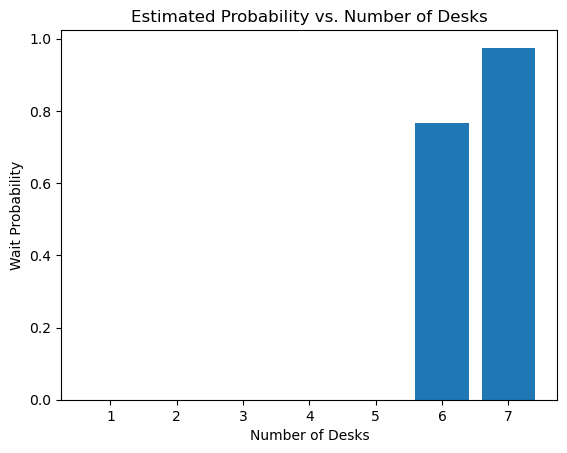

In [10]:
#plotting the estimated probability vs the number of desks
plt.bar(desk_counts, batch_estimated_prob)
plt.xlabel('Number of Desks')
plt.ylabel('Wait Probability')
plt.title('Estimated Probability vs. Number of Desks')
plt.show()

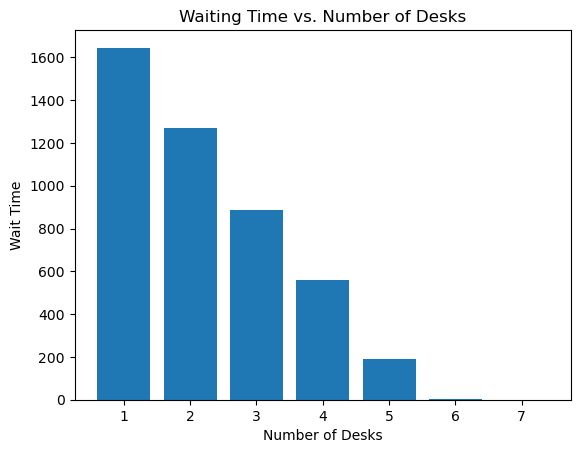

In [11]:
#Calculating the estimated waiting time vs the number of desks
plt.bar(desk_counts, batch_estimated_time)
plt.xlabel('Number of Desks')
plt.ylabel('Wait Time')
plt.title('Waiting Time vs. Number of Desks')
plt.show()